In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno

In [30]:
train_df = pd.read_csv("data/train.csv", index_col="PassengerId")
train_shape = train_df.shape
display(train_df.head())
print(f"Entries: {train_shape[0]}\nFeatures: {train_shape[1]}")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Entries: 891
Features: 11


In [31]:
# initial dtypes of each column
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


<Axes: >

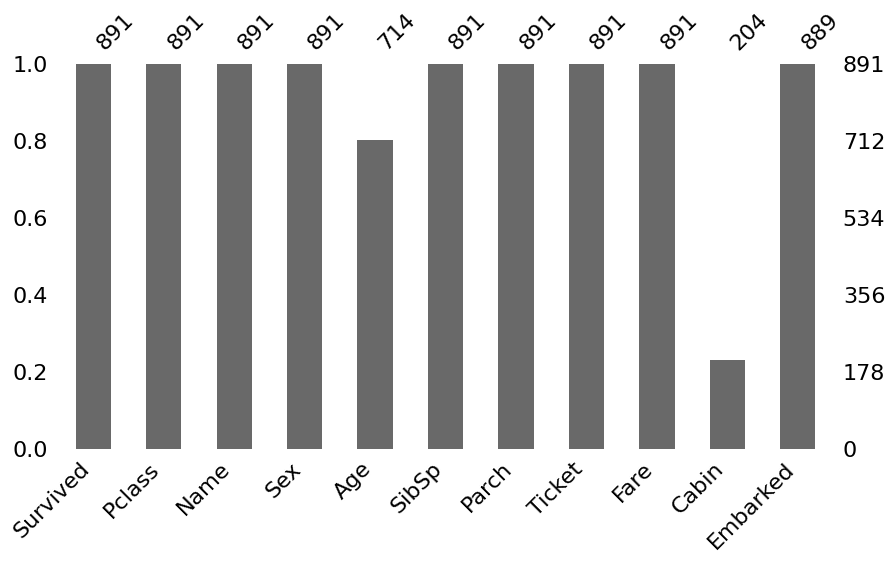

In [32]:
#  null entries
msno.bar(train_df, figsize=(10,5))

In [33]:
#  number of unique values
train_df.nunique()

Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64

In [34]:
#  check if there are duplicated passengers
count_duplicated_passengers = train_df.Name.duplicated().sum()
print(f"There are {count_duplicated_passengers} duplicated passengers in this log.")

There are 0 duplicated passengers in this log.


What needs to be done:
1. reformat column names -> lowercase 
2. deal with entries/features with null values: impute or drop

In [35]:
#  reformat column names
train_df.columns = train_df.columns.str.lower()
train_df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [36]:
#  check entries with null Age values
null_age = train_df.age.isna()
display(train_df[null_age].head())
print(f"There are {null_age.sum()} passengers with no age specified.")
print(f"That is {(null_age.sum() / train_df.shape[0]) * 100:.2f}% of the entire train_df with no specified age")

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q


There are 177 passengers with no age specified.
That is 19.87% of the entire train_df with no specified age


In [37]:
# #  impute values with average or drop entries with no ages?
# def age_solution(df):
#     return

# train_df = age_solution(train_df)

In [38]:
#  check entries with null Cabin values
null_cabin = train_df.cabin.isna()
display(train_df[null_cabin].head())
print(f"There are {null_cabin.sum()} passengers with no cabin specified.")
print(f"That is {(null_cabin.sum() / train_df.shape[0]) * 100:.2f}% of the entire train_df with no specified cabin ID")

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


There are 687 passengers with no cabin specified.
That is 77.10% of the entire train_df with no specified cabin ID


In [39]:
# #  drop column altogether?
# def cabin_solution(df):
#     return

# train_df = cabin_solution(train_df)

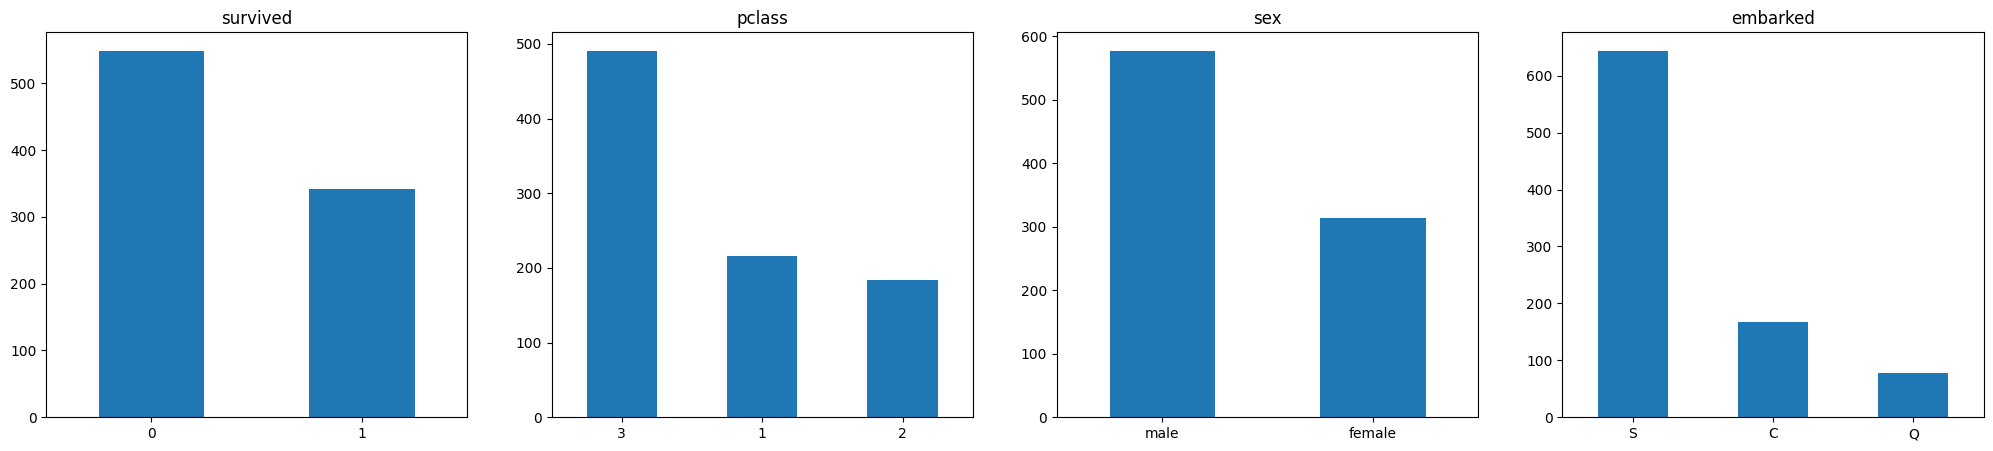

In [40]:
fig, axs = plt.subplots(1,4, figsize=(25,5))

bar_list = ["survived", 
            "pclass",
            "sex",
            "embarked",]

for i, col in enumerate(bar_list):
    train_df[col].value_counts().plot(kind="bar",
                       ax=axs[i],
                       rot=0)
    axs[i].set_title(col)

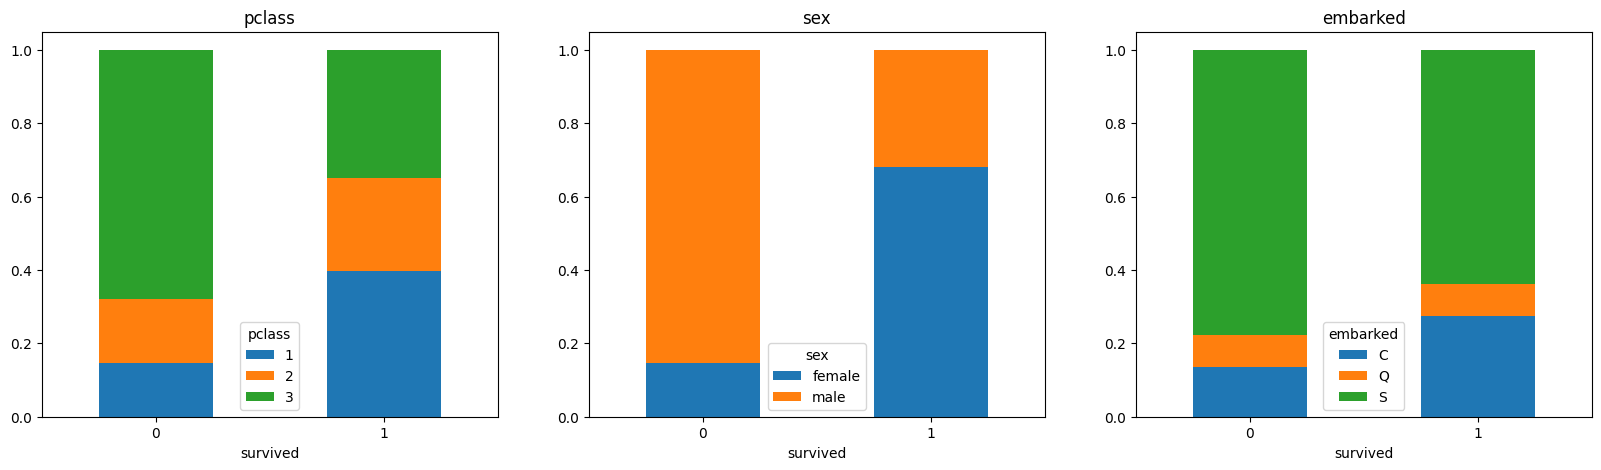

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))

col_list = ["pclass",
            "sex",
            "embarked",]

for i, col in enumerate(col_list):
    pd.crosstab(train_df["survived"], train_df[col], normalize="index").plot.bar(stacked=True, ax=axs[i], rot=0)
    axs[i].set_title(col)

Mean Age: 29.70
Median Age: 28.0

Mean Fare: 32.20
Median Fare: 14.45


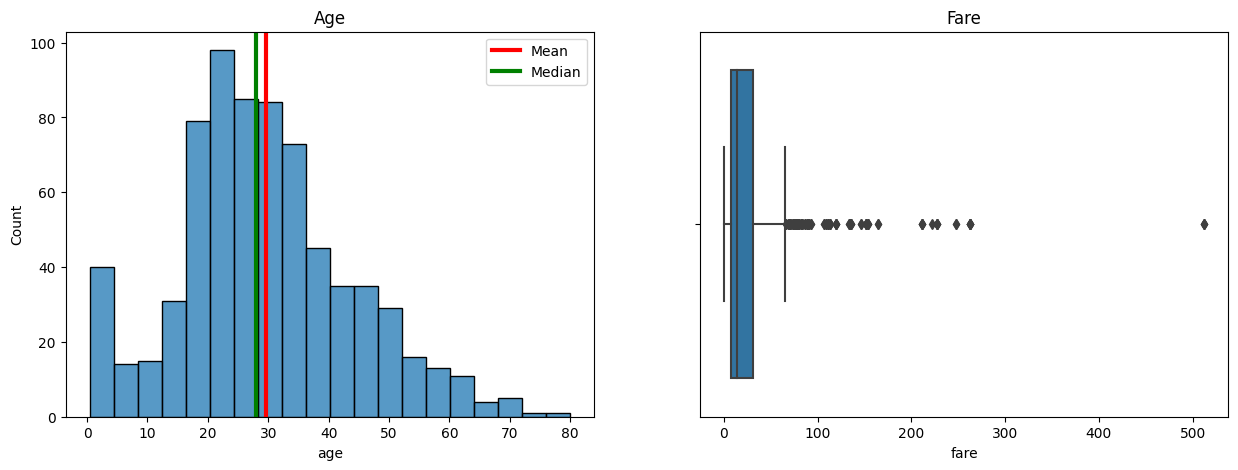

In [42]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

sns.histplot(data=train_df,
             x="age",
             ax=axs[0])
axs[0].set_title("Age")
axs[0].axvline(x=train_df.age.mean(),
               linewidth=3, 
               color='r',
               label="Mean"
               )
axs[0].axvline(x=train_df.age.median(),
               linewidth=3, 
               color='g',
               label="Median"
               )
axs[0].legend()

sns.boxplot(data=train_df,
            x="fare",
            ax=axs[1])
axs[1].set_title("Fare")

print(f"Mean Age: {train_df.age.mean():.2f}")
print(f"Median Age: {train_df.age.median()}\n")
print(f"Mean Fare: {train_df.fare.mean():.2f}")
print(f"Median Fare: {train_df.fare.median():.2f}")

mean               min          max      
sex          female       male female  male female  male
survived                                                
0         25.046875  31.618056   2.00  1.00   57.0  74.0
1         28.847716  27.276022   0.75  0.42   63.0  80.0

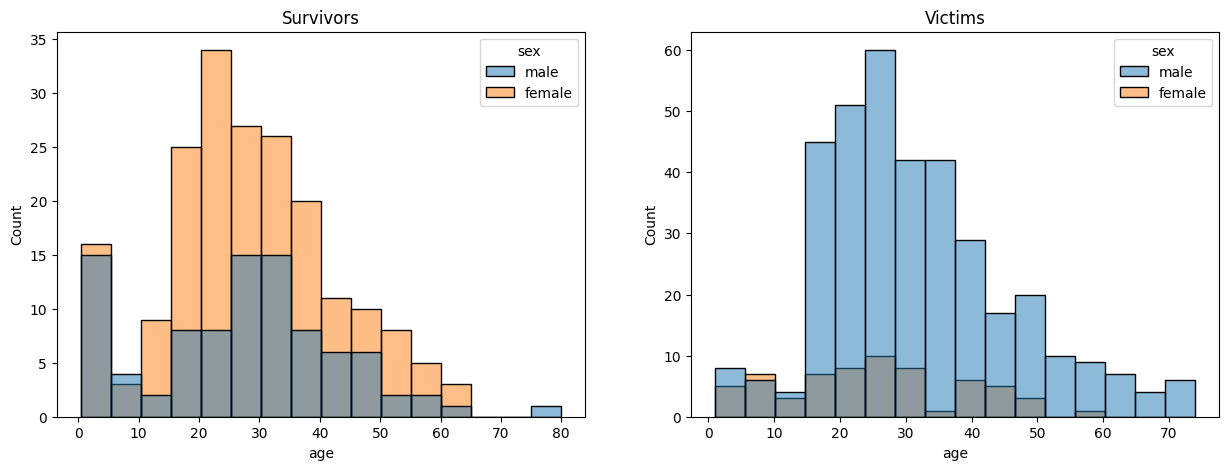

In [43]:
survivors = train_df.query("survived == 1")
victims = train_df.query("survived == 0")

fig, axs = plt.subplots(1,2, figsize=(15,5))

sns.histplot(data=survivors,
             x="age",
             hue="sex",
             ax=axs[0],
             hue_order=["male", "female"]
             )
axs[0].set_title("Survivors")

sns.histplot(data=victims,
             x="age",
             hue="sex",
             ax=axs[1],
             hue_order=["male", "female"]
             )
axs[1].set_title("Victims")

sex_numerical = pd.crosstab(train_df.survived, train_df.sex, train_df.age, aggfunc=[np.mean, min, max])
display(sex_numerical)

mean                         min                max            
pclass            1          2          3     1      2     3     1     2     3
survived                                                                      
0         43.695312  33.544444  26.555556  2.00  16.00  1.00  71.0  70.0  74.0
1         35.368197  25.901566  20.646118  0.92   0.67  0.42  80.0  62.0  63.0

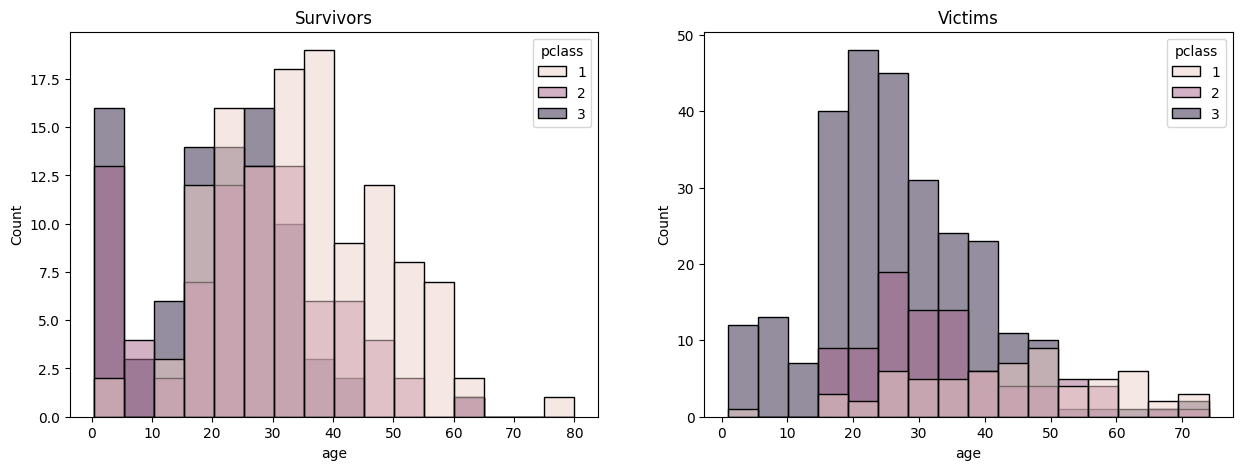

In [44]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

sns.histplot(data=survivors,
             x="age",
             hue="pclass",
             ax=axs[0],
             hue_order=["male", "female"]
             )
axs[0].set_title("Survivors")

sns.histplot(data=victims,
             x="age",
             hue="pclass",
             ax=axs[1],
             hue_order=["male", "female"]
             )
axs[1].set_title("Victims")

pclass_numerical = pd.crosstab(train_df.survived, train_df.pclass, train_df.age, aggfunc=[np.mean, min, max])
display(pclass_numerical)